## MDS Thesis
#### 04. Visualize GELECTRA prediction results

<br>
<hr style="opacity: 0.5">

### Setup

In [106]:
# had to install statsmodels this way
#!/Users/varvarailyina/hertie/mds_thesis/env/bin/python -m pip install statsmodels

In [107]:
# load libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

In [108]:
# set wd
ROOT_DIR = "/Users/varvarailyina/hertie/mds_thesis/data"

-- *Load data*

In [109]:
# load data
df_ed8 = pd.read_csv(os.path.join(ROOT_DIR, "out", "df_res_ed8.csv"))
df_gelectra = pd.read_pickle(os.path.join(ROOT_DIR, "out", "df_res_gelectra.pkl"))

In [110]:
df_gelectra.columns

Index(['party', 'date', 'month', 'issue_mono', 'issue_label', 'text', 'anger',
       'fear', 'disgust', 'sadness', 'joy', 'enthusiasm', 'pride', 'hope',
       'n_sentences', 'total_emotion_mentions', 'emotion_intensity',
       'anger_share', 'fear_share', 'disgust_share', 'sadness_share',
       'joy_share', 'enthusiasm_share', 'pride_share', 'hope_share'],
      dtype='object')

In [111]:
# only keep press releases with > 3 sentences
df_gelectra = df_gelectra[df_gelectra['n_sentences'] >= 4].copy()

-- *Clean `month` column*

In [112]:
# convert to string
df_gelectra['month'] = df_gelectra['month'].astype(str)

# convert to datetime (adds '20' prefix to turn '1307' → '2013-07-01')
df_gelectra['month_dt'] = pd.to_datetime('20' + df_gelectra['month'], format='%Y%m')

# remove time and replace `month` variable
df_gelectra['month'] = df_gelectra['month_dt'].dt.strftime('%Y-%m')

-- *Clean `date` column*

In [113]:
# convert `date` to a string
df_gelectra['date'] = pd.to_datetime(df_gelectra['date']).dt.date
df_gelectra['date'] = df_gelectra['date'].astype(str)

-- *Clean df for plotting emotion shares*

In [114]:
# define columns with emotion shares
emotion_share_cols = [col for col in df_gelectra.columns if col.endswith('_share')]

# melt df for plotting
df_shares = df_gelectra.melt(
    id_vars=['party'],
    value_vars=emotion_share_cols,
    var_name='emotion',
    value_name='value'
)

# clean emotion labels
df_shares['emotion'] = df_shares['emotion'].str.replace('_share', '').str.title()

-- *Specify things*

In [115]:
# specify emotion columns
emotion_cols = ['anger', 'fear', 'disgust', 'sadness', 'joy', 'enthusiasm', 'pride', 'hope']

In [116]:
# define party colors
party_colors = {
    'CDU/CSU': '#000000',
    'SPD': '#E3000F',
    'Greens': '#46962B',
    'FDP': '#FFED00',
    'Left': '#8C3473',
    'AfD': '#009EE0'
}

# define emotion colors
emotion_colors = {
    #'anger': '#b2182b',
    'anger': '#e66101',
    'fear': '#5e3c99',
    'disgust': '#1b7837',
    'sadness': '#2166ac',
    'joy': '#fdb863',
    'enthusiasm': '#b2abd2',
    'pride': '#d01c8b',
    'hope': '#80cdc1'
}

In [117]:
# important events
election_2013 = pd.to_datetime('2013-09-22')  # 2013 election
election_2017 = pd.to_datetime('2017-09-24')  # 2017 election
#merkel_press_conf = pd.to_datetime('2015-08-31')  # merkel: wir schaffen das

event_dates = [election_2013, election_2017]

<hr style="opacity: 0.25">

### Summary statistics

In [129]:
# total number of press releases
total_releases = len(df_gelectra)

-- *emotion statistics*

In [71]:
# define cols for summary stats
summary_cols = ['emotion_intensity'] + emotion_cols  # keeps intensity + all emotions

# compute summary statistics
summary_stats = df_gelectra[summary_cols].describe().T  # Transpose for readability

# clean up col names
summary_stats = summary_stats.rename(columns={
    'count': 'N',
    'mean': 'Mean',
    'std': 'Std. Dev.',
    'min': 'Min',
    '50%': 'Median',
    'max': 'Max'
})

# round
summary_stats = summary_stats.round(4)

# show table
print(summary_stats)

                         N    Mean  Std. Dev.     Min  25th Percentile  \
emotion_intensity  41328.0  0.1942     0.0884  0.0335           0.1312   
anger              41328.0  0.4968     0.2383  0.0126           0.3099   
fear               41328.0  0.2041     0.1319  0.0047           0.1028   
disgust            41328.0  0.0484     0.0561  0.0007           0.0119   
sadness            41328.0  0.1800     0.1264  0.0046           0.0852   
joy                41328.0  0.1208     0.1323  0.0042           0.0265   
enthusiasm         41328.0  0.2268     0.1308  0.0064           0.1259   
pride              41328.0  0.1515     0.1407  0.0050           0.0497   
hope               41328.0  0.4050     0.1824  0.0086           0.2653   

                   Median  75th Percentile     Max  
emotion_intensity  0.1757           0.2364  0.8075  
anger              0.5256           0.6848  0.9920  
fear               0.1850           0.2814  0.8404  
disgust            0.0295           0.0629  0.7

-- *party frequency*

In [128]:
# party frequency

# count and share by party
party_summary = (
    df_gelectra.groupby('party')
    .size()
    .reset_index(name='N')
)

party_summary['Share (%)'] = (party_summary['N'] / total_releases * 100).round(2)

print(party_summary)

     party     N  Share (%)
0      AfD  3314       8.02
1  CDU/CSU  6274      15.18
2      FDP  5448      13.18
3   Greens  8056      19.49
4     Left  9709      23.49
5      SPD  8527      20.63


-- *issue saliency*

In [126]:
# count and share by issue
issue_summary = (
    df_gelectra.groupby('issue_label')
    .size()
    .reset_index(name='N')
)

issue_summary['Share (%)'] = (issue_summary['N'] / total_releases * 100).round(2)

print(issue_summary)

              issue_label     N  Share (%)
0             Agriculture  1592       3.85
1            Civil Rights  3161       7.65
2                 Culture   319       0.77
3                 Defense  1884       4.56
4       Domestic Commerce  2662       6.44
5               Education  2294       5.55
6                  Energy  2071       5.01
7             Environment  1322       3.20
8    European Integration  2444       5.91
9           Foreign Trade   461       1.12
10  Government Operations  1369       3.31
11                 Health  1783       4.31
12                Housing   631       1.53
13            Immigration  2221       5.37
14  International Affairs  5629      13.62
15                  Labor  2786       6.74
16          Law and Crime  2800       6.78
17         Macroeconomics  2273       5.50
18         Social Welfare  1234       2.99
19             Technology   978       2.37
20         Transportation  1414       3.42


<hr style="opacity: 0.25">

### Visualize results (emotional intensity)

-- *Emotional intensity by party*

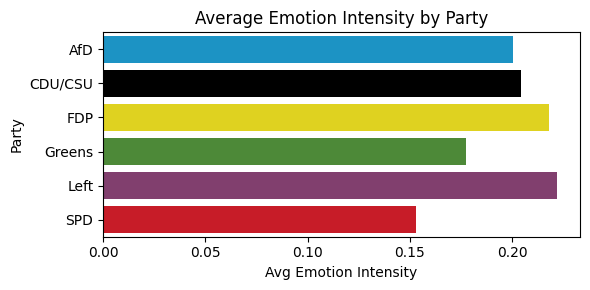

In [72]:
# average emotion intensity by party
plt.figure(figsize=(6, 3))
sns.barplot(
    data=df_gelectra,
    x='emotion_intensity',
    y='party',
    hue='party',
    dodge=False,
    estimator=np.mean,
    errorbar=None,
    palette=party_colors,
    legend=False
)
plt.title('Average Emotion Intensity by Party')
plt.xlabel('Avg Emotion Intensity')
plt.ylabel('Party')
plt.tight_layout()
plt.show()

-- *Most emotional press releases*

In [73]:
# top 10 most emotional press releases
top_emotional = df_gelectra.sort_values(by='emotion_intensity', ascending=False).head(10)

# print preview
print(top_emotional[['party', 'date', 'emotion_intensity', 'text']])

         party        date  emotion_intensity  \
1903       AfD  2018-07-02           0.807538   
7460   CDU/CSU  2015-02-04           0.788140   
24084     Left  2010-09-01           0.733147   
7514   CDU/CSU  2015-03-02           0.698659   
4250   CDU/CSU  2011-02-02           0.697769   
26334     Left  2012-06-23           0.696293   
30648     Left  2016-07-15           0.693668   
5519   CDU/CSU  2012-07-30           0.687104   
6853   CDU/CSU  2014-04-21           0.685102   
22325   Greens  2017-09-04           0.675981   

                                                    text  
1903   Zum neuerlichen Fall von Antisemitismus in Ber...  
7460   „Die barbarischen Taten dieser entmenschlichte...  
24084  „Mit ihrem blutigen Anschlag auf vier israelis...  
7514   „Der Mord am russischen Oppositionspolitiker B...  
4250   „Es ist zutiefst bedauerlich, dass auf europäi...  
26334  „Die aktuelle politische Situation in Paraguay...  
30648  Zum Terroranschlag von Nizza erklären di

In [74]:
top_emotional

party        date    month  issue_mono            issue_label  \
1903       AfD  2018-07-02  2018-07           2           Civil Rights   
7460   CDU/CSU  2015-02-04  2015-02         191  International Affairs   
24084     Left  2010-09-01  2010-09         191  International Affairs   
7514   CDU/CSU  2015-03-02  2015-03         191  International Affairs   
4250   CDU/CSU  2011-02-02  2011-02         191  International Affairs   
26334     Left  2012-06-23  2012-06         191  International Affairs   
30648     Left  2016-07-15  2016-07         191  International Affairs   
5519   CDU/CSU  2012-07-30  2012-07         191  International Affairs   
6853   CDU/CSU  2014-04-21  2014-04         191  International Affairs   
22325   Greens  2017-09-04  2017-09         191  International Affairs   

                                                    text     anger      fear  \
1903   Zum neuerlichen Fall von Antisemitismus in Ber...  0.921782  0.747339   
7460   „Die barbarischen Taten dieser entmenschlichte...  0.635679  0.616843   
24084  „Mit ihrem blutigen Anschlag auf vier israelis...  0.874725  0.706548   
7514   „Der Mord am russischen Oppositionspolitiker B...  0.708155  0.631984   
4250   „Es ist zutiefst bedauerlich, dass auf europäi...  0.721375  0.567892   
26334  „Die aktuelle politische Situation in Paraguay...  0.424029  0.400614   
30648  Zum Terroranschlag von Nizza erklären die Vors...  0.534098  0.601034   
5519   „Die Aufstellung Julia Timoschenkos als Spitze...  0.247962  0.065368   
6853   „Zum Jahrestag der Entführung des syrischortho...  0.233513  0.206491   
22325  Zur Eskalation der Kämpfe zwischen der Armee u...  0.633163  0.745843   

        disgust   sadness  ...  emotion_intensity  anger_share  fear_share  \
1903   0.734150  0.734736  ...           0.807538        28.54       23.14   
7460   0.611757  0.878772  ...           0.788140        20.16       19.57   
24084  0.437602  0.701813  ...           0.733147        29.83       24.09   
7514   0.149144  0.658792  ...           0.698659        25.34       22.61   
4250   0.344546  0.784861  ...           0.697769        25.85       20.35   
26334  0.044959  0.235050  ...           0.696293        15.22       14.38   
30648  0.375263  0.793574  ...           0.693668        19.25       21.66   
5519   0.052055  0.150430  ...           0.687104         9.02        2.38   
6853   0.077954  0.388319  ...           0.685102         8.52        7.54   
22325  0.145732  0.733704  ...           0.675981        23.42       27.58   

       disgust_share  sadness_share  joy_share  enthusiasm_share  pride_share  \
1903           22.73          22.75       0.60              0.81         0.46   
7460           19.41          27.87       1.09              4.18         2.43   
24084          14.92          23.93       0.50              1.88         0.51   
7514            5.34          23.57       0.90              8.58         2.01   
4250           12.34          28.12       0.54              4.22         1.90   
26334           1.61           8.44       1.10             25.06         3.86   
30648          13.52          28.60       1.28              5.31         1.48   
5519            1.89           5.47      19.78             15.71        27.04   
6853            2.84          14.17       5.05             20.54        15.90   
22325           5.39          27.13       0.66              6.19         1.07   

       hope_share   month_dt  
1903         0.98 2018-07-01  
7460         5.28 2015-02-01  
24084        4.33 2010-09-01  
7514        11.64 2015-03-01  
4250         6.68 2011-02-01  
26334       30.32 2012-06-01  
30648        8.89 2016-07-01  
5519        18.70 2012-07-01  
6853        25.44 2014-04-01  
22325        8.56 2017-09-01  

[10 rows x 26 columns]

<hr style="opacity: 0.25">

### Visualize results (average emotions)

-- *Averaged probabilities of each emotion across all press releases*

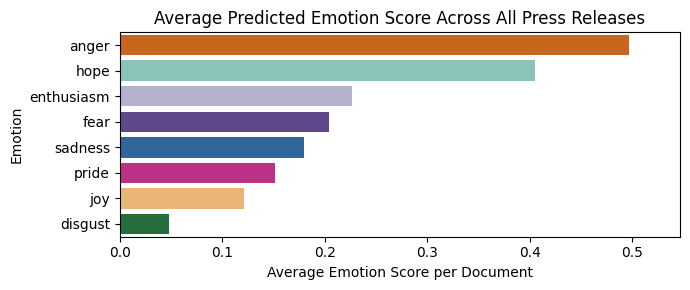

In [75]:
# sum predicted probabilities across all documents
emotion_totals = df_gelectra[emotion_cols].sum().sort_values(ascending=False)

# convert to df
emotion_df = emotion_totals.reset_index()
emotion_df.columns = ['emotion', 'total_score']

# find average emotion per document
emotion_df['average_score'] = emotion_df['total_score'] / len(df_gelectra)

# plot
plt.figure(figsize=(7, 3))
sns.barplot(
    data=emotion_df,
    x='average_score',
    y='emotion',
    hue='emotion',
    dodge=False,
    palette=emotion_colors,
    legend=False
)

plt.title('Average Predicted Emotion Score Across All Press Releases')
plt.xlabel('Average Emotion Score per Document')
plt.ylabel('Emotion')
plt.xlim(0, emotion_df['average_score'].max() * 1.1)  # add spacing
plt.tight_layout()
plt.show()

-- *Average of all emotion scores per document*

In [76]:
# generate avg emotion score across all 8 emotions
df_gelectra['avg_emotion_score'] = df_gelectra[emotion_cols].mean(axis=1)

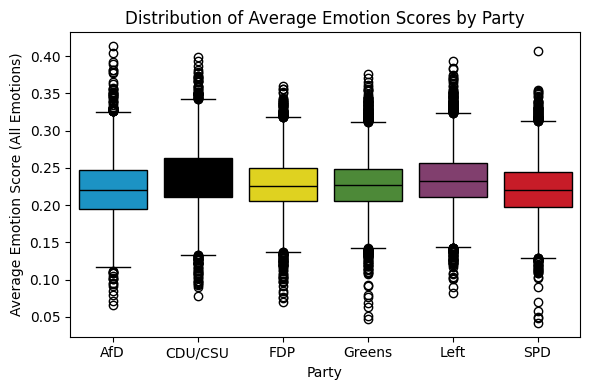

In [77]:
# box plot
plt.figure(figsize=(6, 4))
sns.boxplot(
    data=df_gelectra,
    x='party',
    y='avg_emotion_score',
    hue='party',
    palette=party_colors,
    dodge=False,
    legend=False
)
plt.title('Distribution of Average Emotion Scores by Party')
plt.xlabel('Party')
plt.ylabel('Average Emotion Score (All Emotions)')
plt.tight_layout()
plt.show()

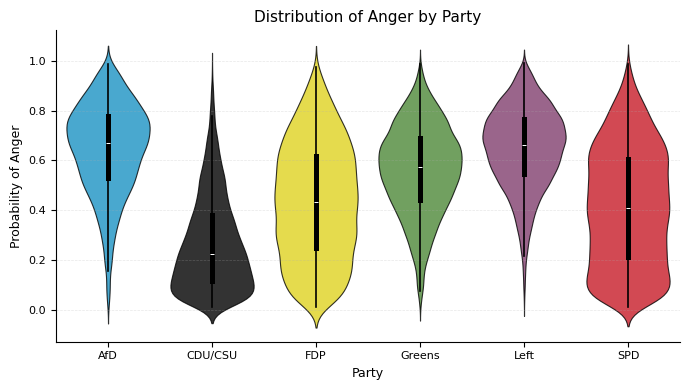

In [78]:
# distribution of anger
plt.figure(figsize=(7, 4))

sns.violinplot(
    data=df_gelectra,
    x='party',
    y='anger',
    hue='party',
    palette=party_colors,
    inner='box',
    dodge=False,
    legend=False,
    linewidth=0.8,
    alpha=0.8
)

# title and labels
plt.title('Distribution of Anger by Party', fontsize=11)
plt.xlabel('Party', fontsize=9)
plt.ylabel('Probability of Anger', fontsize=9)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# tweak style
sns.despine()
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.3)

plt.tight_layout()
plt.show()

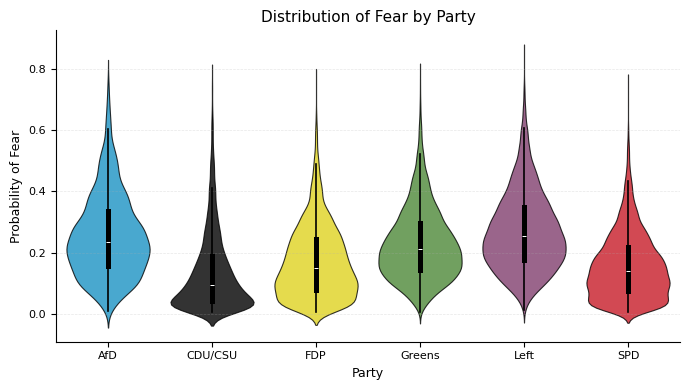

In [79]:
# distribution of fear
plt.figure(figsize=(7, 4))

sns.violinplot(
    data=df_gelectra,
    x='party',
    y='fear',
    hue='party',
    palette=party_colors,
    inner='box',
    dodge=False,
    legend=False,
    linewidth=0.8,
    alpha=0.8
)

# title and labels
plt.title('Distribution of Fear by Party', fontsize=11)
plt.xlabel('Party', fontsize=9)
plt.ylabel('Probability of Fear', fontsize=9)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# tweak style
sns.despine()
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.3)

plt.tight_layout()
plt.show()

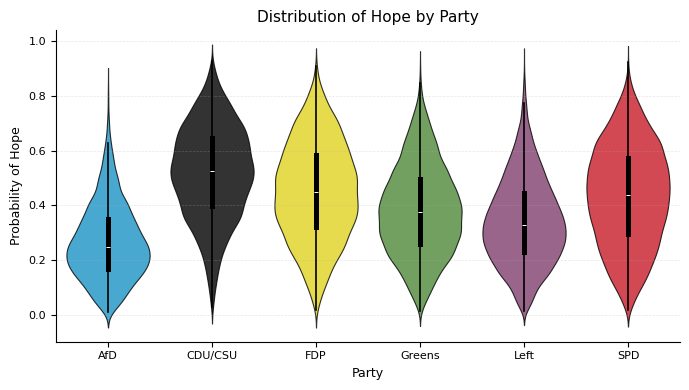

In [80]:
# distribution of hope
plt.figure(figsize=(7, 4))

sns.violinplot(
    data=df_gelectra,
    x='party',
    y='hope',
    hue='party',
    palette=party_colors,
    inner='box',
    dodge=False,
    legend=False,
    linewidth=0.8,
    alpha=0.8
)

# title and labels
plt.title('Distribution of Hope by Party', fontsize=11)
plt.xlabel('Party', fontsize=9)
plt.ylabel('Probability of Hope', fontsize=9)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# tweak style
sns.despine()
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.3)

plt.tight_layout()
plt.show()

<hr style="opacity: 0.25">

### Visualize results (emotion shares)

-- *Barplot of average emotion shares by party*

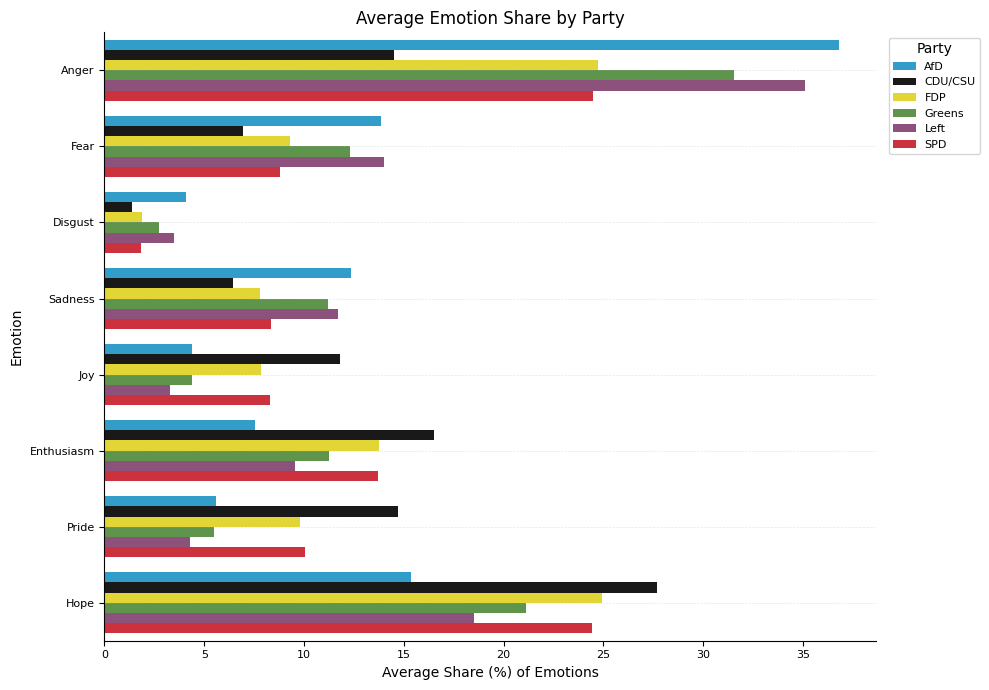

In [81]:
# share of each emotion by party
plt.figure(figsize=(10, 7))

sns.barplot(
    data=df_shares,
    x='value',
    y='emotion',
    hue='party',
    palette=party_colors,
    errorbar=None,
    alpha=0.9)

# title and labels
plt.title('Average Emotion Share by Party', fontsize=12)
plt.xlabel('Average Share (%) of Emotions')
plt.ylabel('Emotion')
plt.legend(title='Party', bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

sns.despine()
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.3)

plt.tight_layout()
plt.show()

In [82]:
# appendix
# add regression to prove hypothesis (anger/not anger vs. party)
# bivariate over every party, get coefficients

-- *Distribution of each emotion across parties*

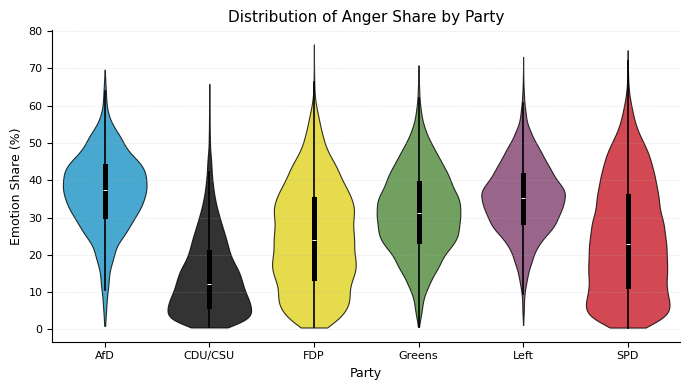

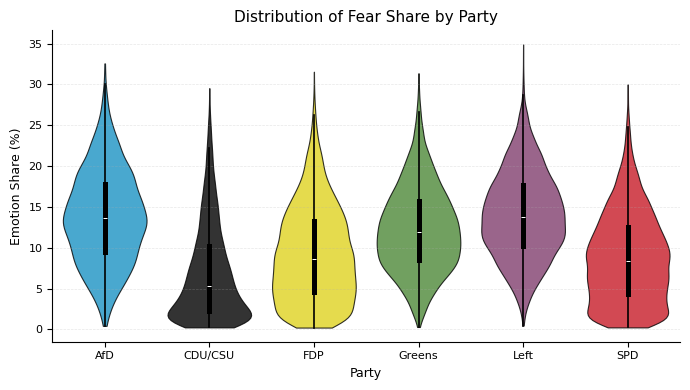

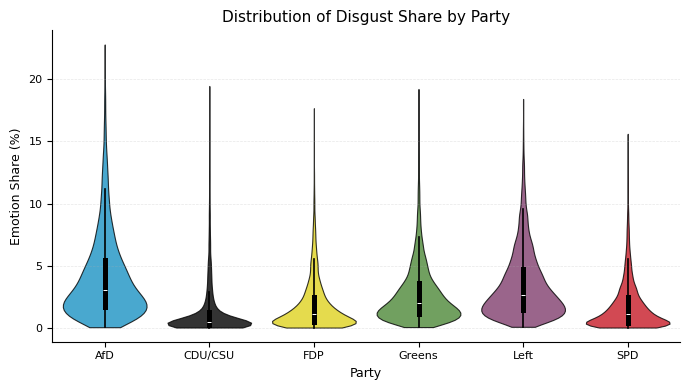

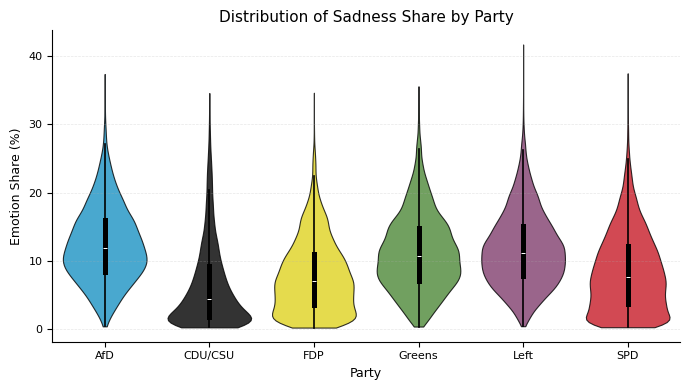

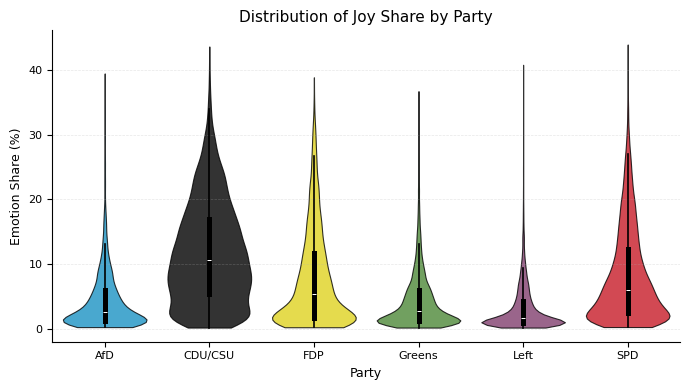

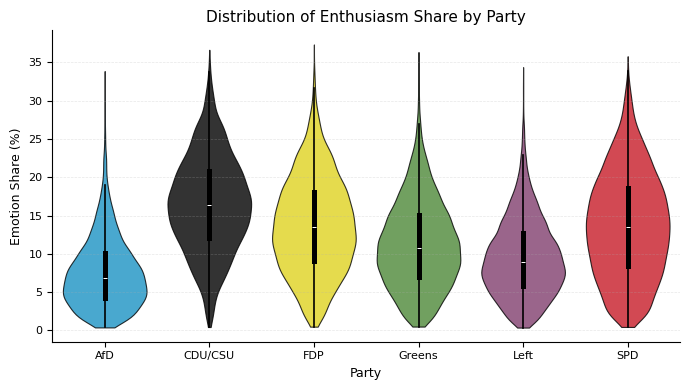

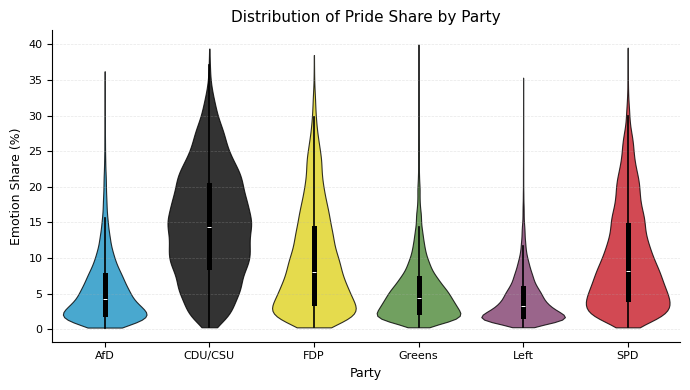

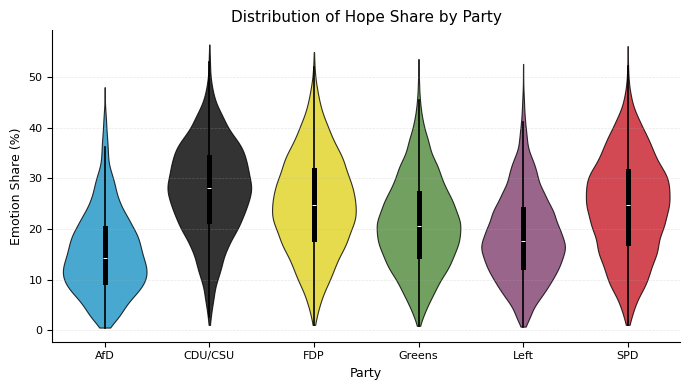

In [83]:
# loop over each emotion for violin plots by party
for emotion in df_shares['emotion'].unique():
    plt.figure(figsize=(7, 4))

    sns.violinplot(
    data=df_shares[df_shares['emotion'] == emotion],
    x='party',
    y='value',
    hue='party',
    palette=party_colors,
    inner='box',
    cut=0,
    dodge=False,
    legend=False,
    linewidth=0.8,
    alpha=0.8
)
    
    plt.title(f'Distribution of {emotion} Share by Party', fontsize=11)
    plt.xlabel('Party', fontsize=9)
    plt.ylabel('Emotion Share (%)', fontsize=9)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    #plt.xticks(rotation=45)

    sns.despine()
    plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.3)

    plt.tight_layout()
    plt.show()

-- *Stacked area plot of emotion share by party over time*

In [84]:
# reorder columns by color palette
emotion_order = list(emotion_colors.keys())
share_cols_ordered = [f"{emotion}_share" for emotion in emotion_order]

# ensure datetime format for month
df_gelectra['month'] = pd.to_datetime(df_gelectra['date']).dt.to_period('M').dt.to_timestamp()

# full timeline index
full_month_index = pd.date_range(start='2010-01-01', end=df_gelectra['month'].max(), freq='MS')

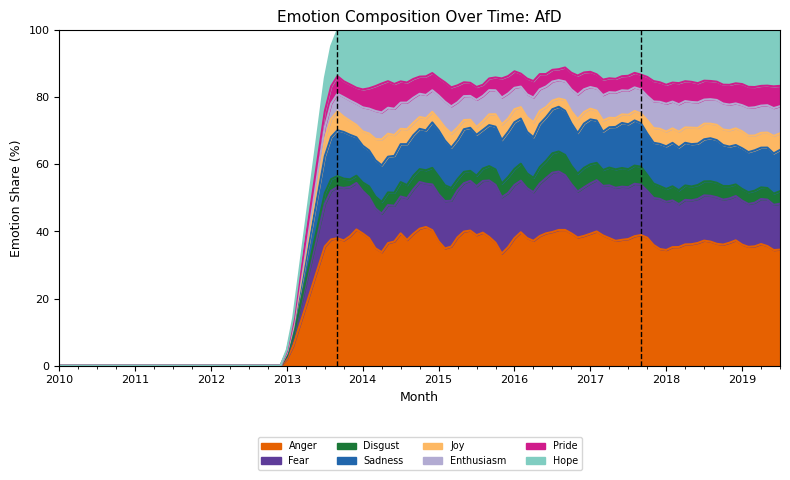

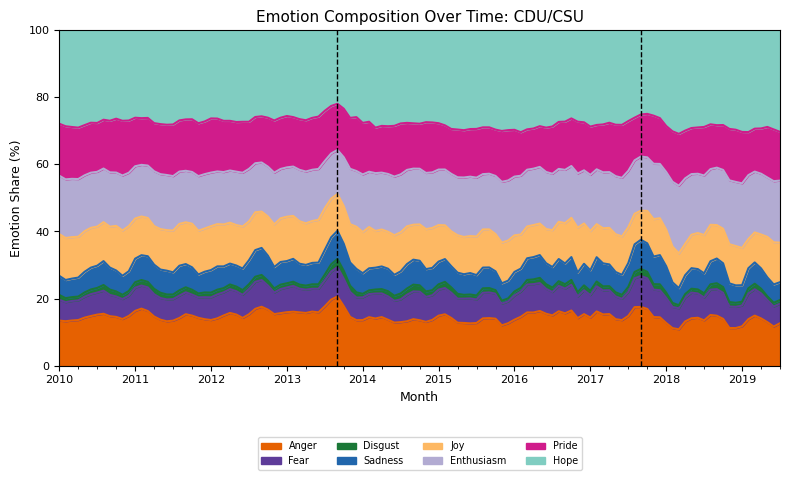

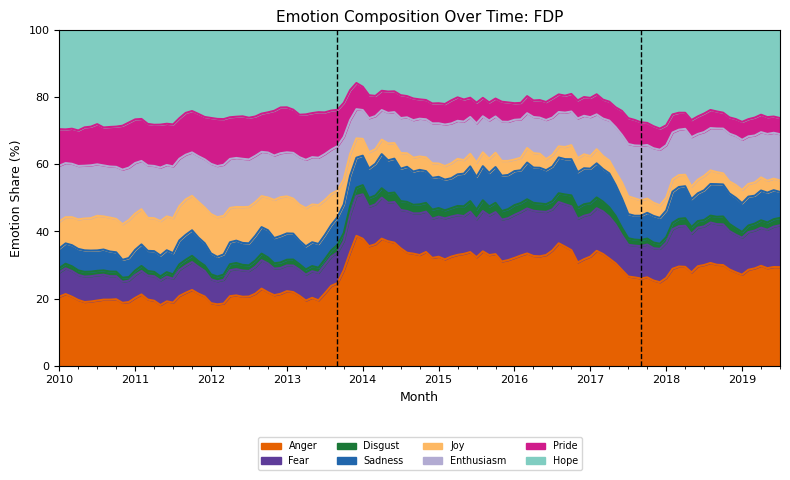

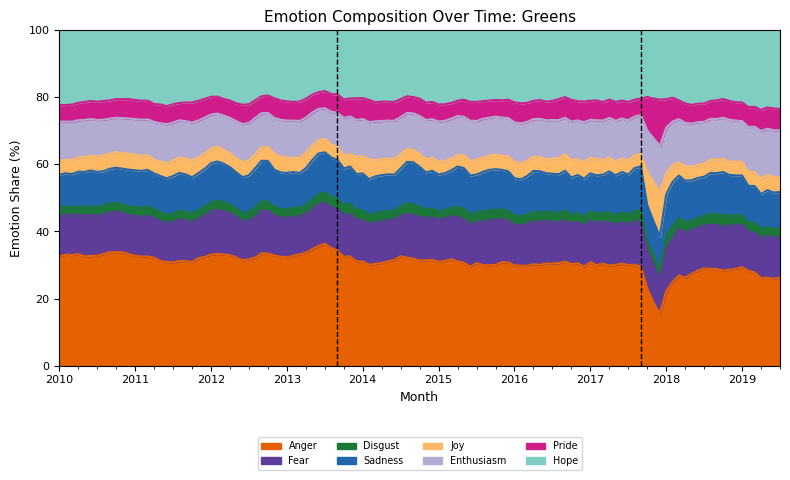

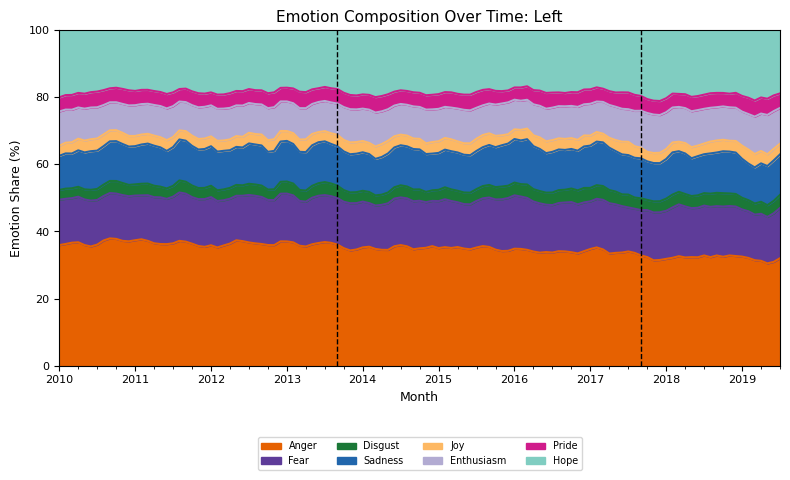

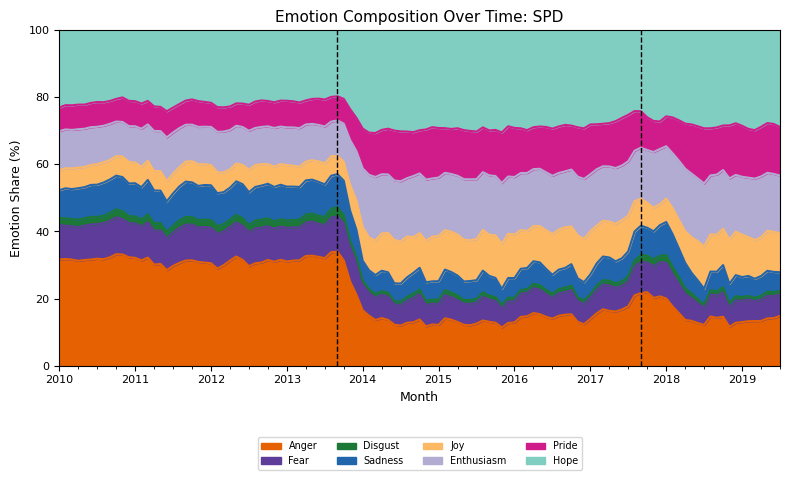

In [85]:
# plot by party
for party in df_gelectra['party'].unique():
    df_party = df_gelectra[df_gelectra['party'] == party]

    # group and average monthly emotion shares
    df_grouped = df_party.groupby('month')[share_cols_ordered].mean()

    # normalize to make shares sum to 100% (just emotions)
    df_grouped = df_grouped.div(df_grouped.sum(axis=1), axis=0) * 100

    # reindex to full timeline
    df_grouped = df_grouped.reindex(full_month_index)

    # fill pre-founding months (AfD before 2013) with zeros
    if party == "AfD":
        founding_date = pd.to_datetime("2013-01-01")
        df_grouped.loc[df_grouped.index < founding_date] = 0

    # interpolate and smooth
    df_grouped = df_grouped.interpolate(method='linear', limit_direction='both')
    df_grouped = df_grouped.rolling(window=3, min_periods=1).mean()

    # plot
    plt.figure(figsize=(8, 5))
    df_grouped.plot(
        kind='area',
        stacked=True,
        ax=plt.gca(),
        color=[emotion_colors[e] for e in emotion_order]
    )

    # add event markers
    for date in event_dates:
        plt.axvline(date, color='black', linestyle='--', linewidth=1)
    
    plt.title(f"Emotion Composition Over Time: {party}", fontsize=11)
    plt.xlabel("Month", fontsize=9)
    plt.ylabel("Emotion Share (%)", fontsize=9)
    plt.ylim(0, 100)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    # grab handles and labels generated by matplotlib
    handles, labels = plt.gca().get_legend_handles_labels()

    # manually relabel without breaking color patch sizes
    new_labels = [label.replace('_share', '').title() for label in labels]

    # use in the legend
    plt.legend(
        handles=handles,
        labels=new_labels,
        loc='upper center',
        bbox_to_anchor=(0.5, -0.2),
        ncol=4,
        fontsize='x-small'
    )

    plt.tight_layout()
    plt.show()

<hr style="opacity: 0.25">

### Visualize results (emotion probabilities)

-- *Distribution of each emotion probability over time*

In [86]:
# melt emotion columns
df_melted = df_gelectra.melt(
    id_vars=['month'],
    value_vars=emotion_cols,
    var_name='emotion',
    value_name='value'
)

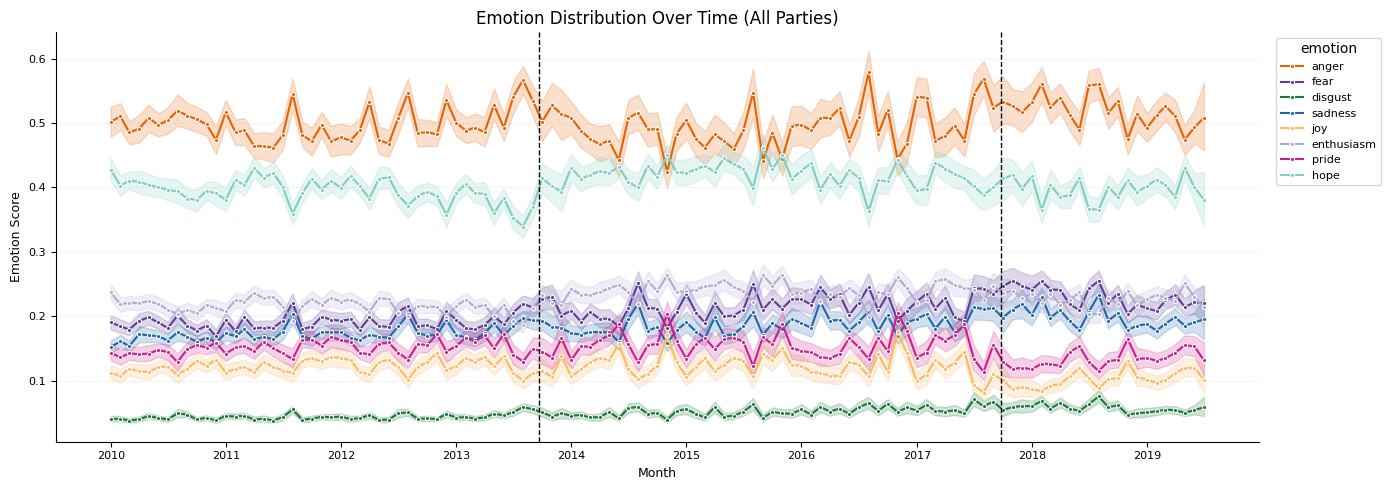

In [87]:
# plot
plt.figure(figsize=(14, 5))

sns.lineplot(
    data=df_melted,
    x='month',
    y='value',
    hue='emotion',
    palette=emotion_colors,
    linewidth=1.5,
    marker='o',
    markersize=3
)

 # add event markers
for date in event_dates:
    plt.axvline(date, color='black', linestyle='--', linewidth=1)

plt.title("Emotion Distribution Over Time (All Parties)", fontsize=12)
plt.xlabel("Month", fontsize=9)
plt.ylabel("Emotion Score", fontsize=9)
plt.legend(title='emotion', bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

sns.despine()
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.3)

plt.tight_layout()
plt.show()

-- *Line plot of each emotion by party over time (monthly)*

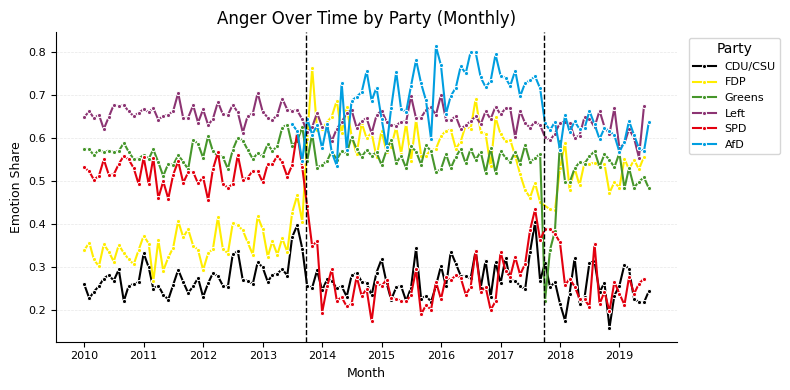

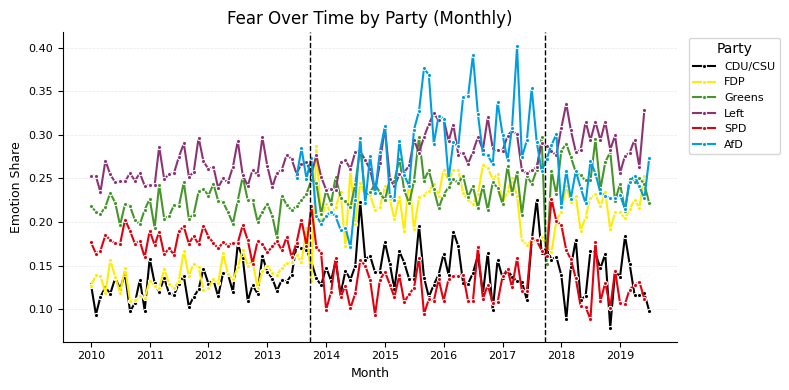

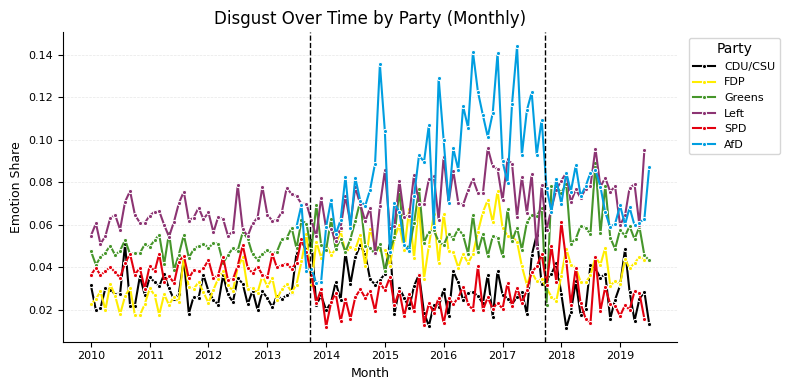

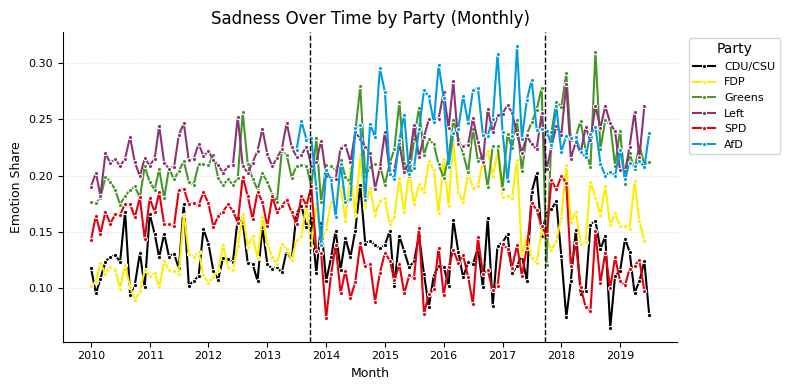

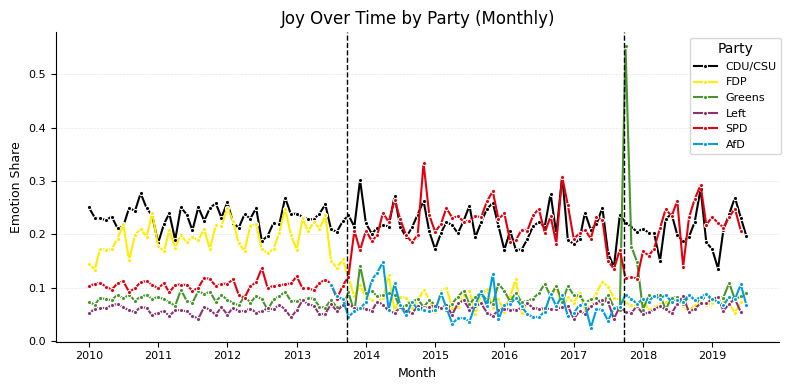

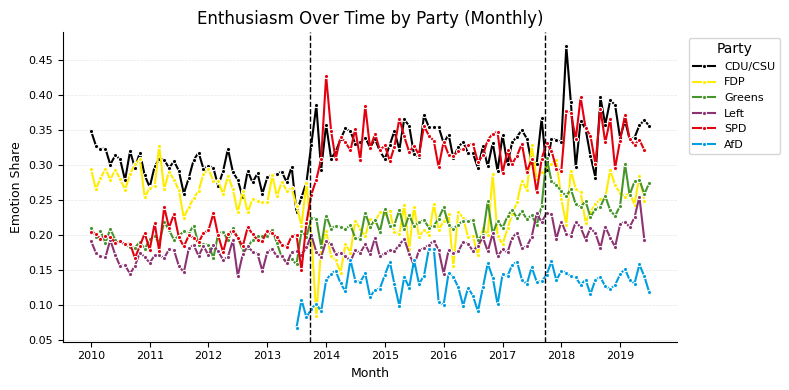

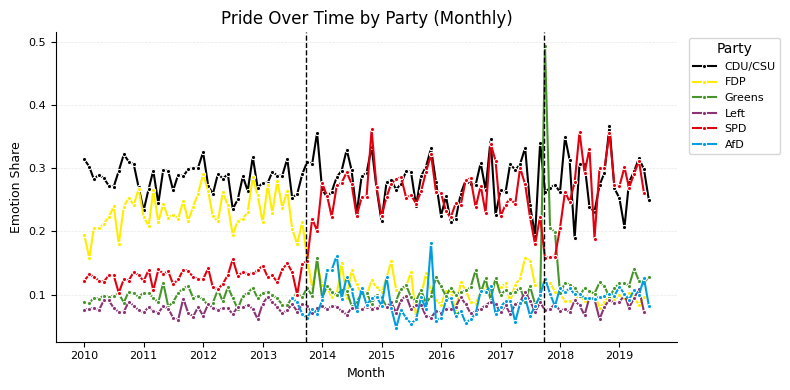

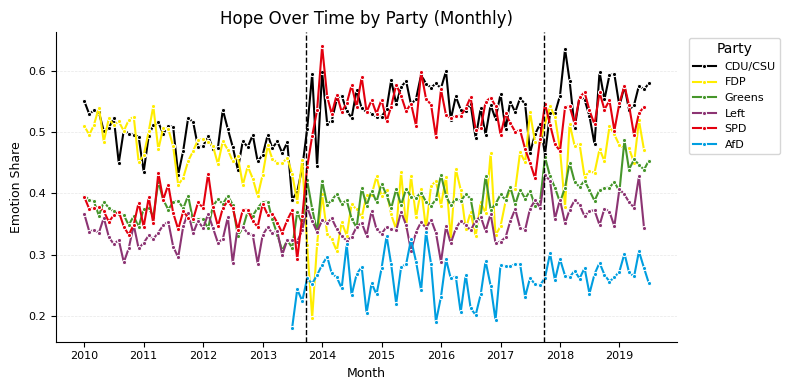

In [88]:
# convert date and create month column
df_gelectra['month'] = pd.to_datetime(df_gelectra['date']).dt.to_period('M').dt.to_timestamp()

# melt emotion columns
df_melted_month = df_gelectra.melt(
    id_vars=['month', 'party'],
    value_vars=emotion_cols,
    var_name='emotion',
    value_name='value'
)

# group by month, party, emotion
df_monthly = df_melted_month.groupby(['month', 'party', 'emotion'])['value'].mean().reset_index()

# plot each emotion over time by party
for emotion in emotion_cols:
    plt.figure(figsize=(8, 4))
    sns.lineplot(
        data=df_monthly[df_monthly['emotion'] == emotion],
        x='month',
        y='value',
        hue='party',
        palette=party_colors,
        marker='o',
        markersize=3,
        linewidth=1.5
    )

     # add event markers
    for date in event_dates:
        plt.axvline(date, color='black', linestyle='--', linewidth=1)
        
    plt.title(f'{emotion.title()} Over Time by Party (Monthly)', fontsize=12)
    plt.legend(title='Party', bbox_to_anchor=(1.01, 1), fontsize=8)
    plt.xlabel('Month', fontsize=9)
    plt.ylabel('Emotion Share', fontsize=9)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    sns.despine()
    plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.3)

    plt.tight_layout()
    plt.show()

-- *Line plot of each emotion by party over time (quarterly)*

In [89]:
# create quarterly period
df_gelectra['quarter'] = pd.to_datetime(df_gelectra['date']).dt.to_period('Q').dt.start_time

# melt emotion columns
df_melted_quarter = df_gelectra.melt(
    id_vars=['quarter', 'party'],
    value_vars=emotion_cols,
    var_name='emotion',
    value_name='value'
)

# reorder emotions in plot
emotion_order = ['anger', 'fear', 'disgust', 'sadness', 'hope', 'joy', 'enthusiasm', 'pride']
#emotion_order = ['anger', 'hope', 'fear', 'joy', 'disgust', 'enthusiasm', 'sadness', 'pride']
df_melted_quarter['emotion'] = pd.Categorical(df_melted_quarter['emotion'], categories=emotion_order, ordered=True)

# group by quarter, party, emotion
df_quarterly = df_melted_quarter.groupby(['quarter', 'party', 'emotion'])['value'].mean().reset_index()

/var/folders/89/wy_4fk_j4wsfym9x7s_1s5jc0000gn/T/ipykernel_89434/679593891.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_quarterly = df_melted_quarter.groupby(['quarter', 'party', 'emotion'])['value'].mean().reset_index()


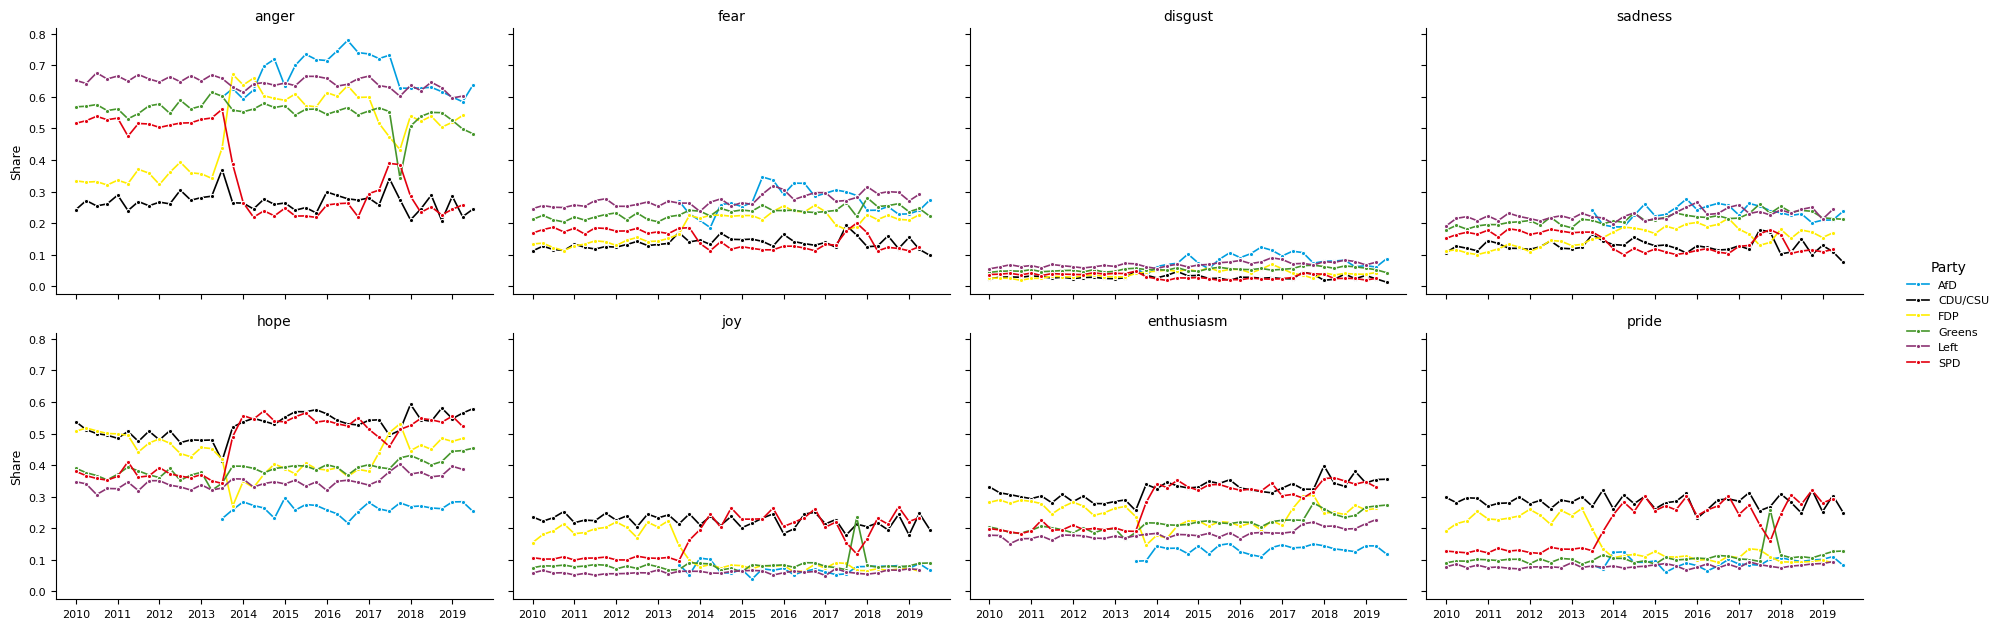

In [90]:
# plot with fixed y-axes across emotions
g = sns.FacetGrid(
    df_quarterly,
    col="emotion",
    col_wrap=4,
    height=3.2,
    sharey=True,  # shared y-axis
    aspect=1.4
)
g.map_dataframe(
    sns.lineplot,
    x="quarter",
    y="value",
    hue="party",
    marker="o",
    linewidth=1.2,
    markersize=3,
    palette=party_colors
)
g.set_titles("{col_name}", fontsize=12)
g.set_axis_labels("", "Share", fontsize=9)
g.add_legend(title="Party", bbox_to_anchor=(1.01, 0.5), loc="center left", fontsize=8)

for ax in g.axes.flat:
    ax.tick_params(axis='both', labelsize=8)

plt.tight_layout()
plt.show()

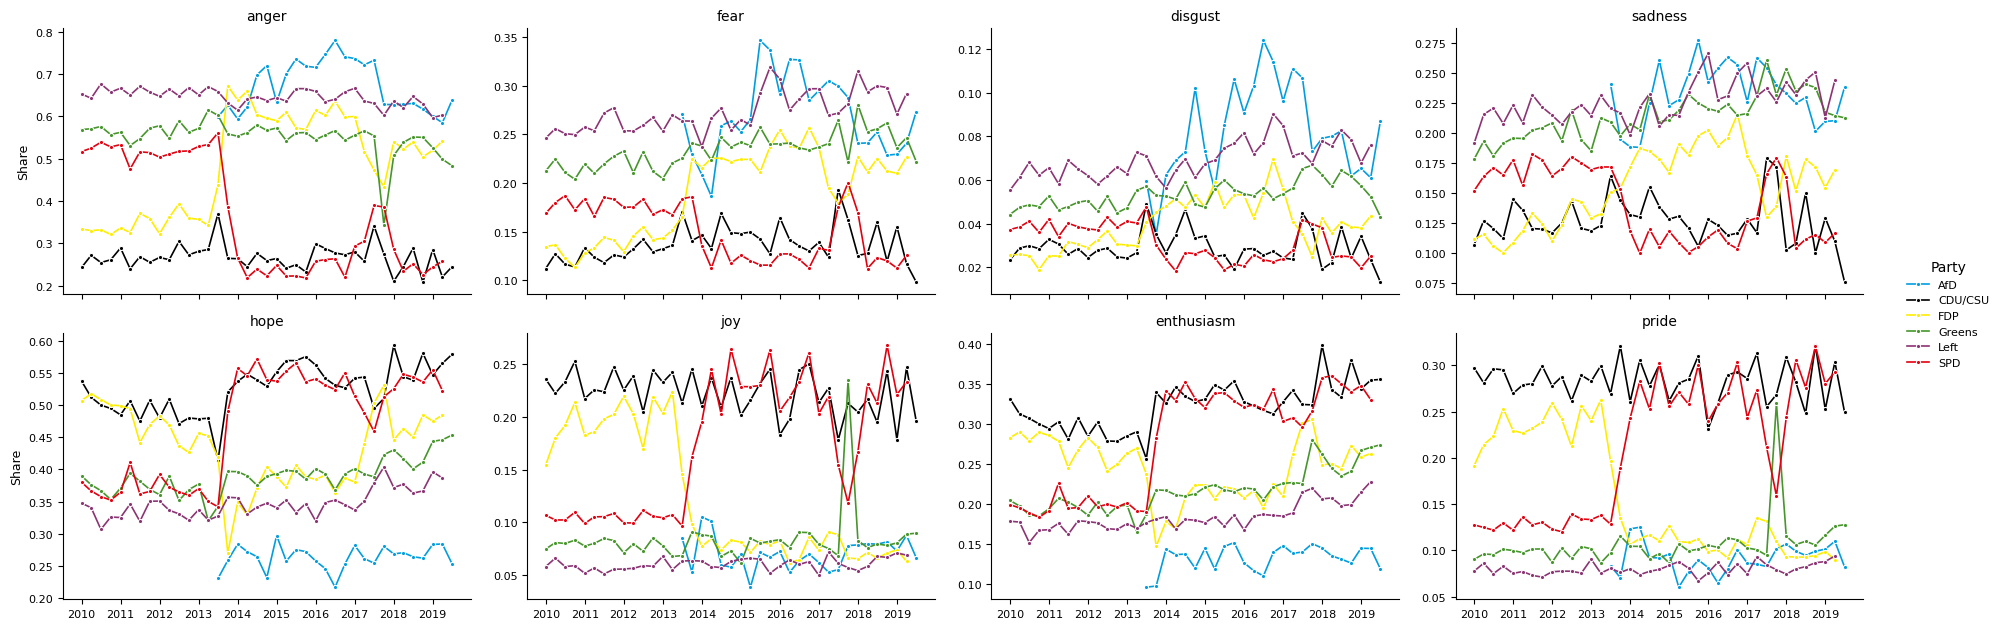

In [91]:
# plot
g = sns.FacetGrid(
    df_quarterly,
    col="emotion",
    col_wrap=4,
    height=3.2,
    sharey=False,
    aspect=1.4
)
g.map_dataframe(
    sns.lineplot,
    x="quarter",
    y="value",
    hue="party",
    marker="o",
    linewidth=1.2,
    markersize=3,
    palette=party_colors
)
g.set_titles("{col_name}", fontsize=12)
g.set_axis_labels("", "Share", fontsize=9)
g.add_legend(title="Party", bbox_to_anchor=(1.01, 0.5), loc="center left", fontsize=8)

for ax in g.axes.flat:
    ax.tick_params(axis='both', labelsize=8)
    
plt.tight_layout()
plt.show()

<hr style="opacity: 0.25">

### Visualize results (by issue)

In [92]:
# specify issue labels
issue_map = {
    1: "Macroeconomics",
    2: "Civil Rights",
    3: "Health",
    4: "Agriculture",
    5: "Labor",
    6: "Education",
    7: "Environment",
    8: "Energy",
    9: "Immigration",
    10: "Transportation",
    12: "Law and Crime",
    13: "Social Welfare",
    14: "Housing",
    15: "Domestic Commerce",
    16: "Defense",
    17: "Technology",
    18: "Foreign Trade",
    20: "Government Operations",
    23: "Culture",
    191: "International Affairs",
    192: "European Integration"
}

-- *Stacked area plot of emotion share by party over time for each party's top issue*

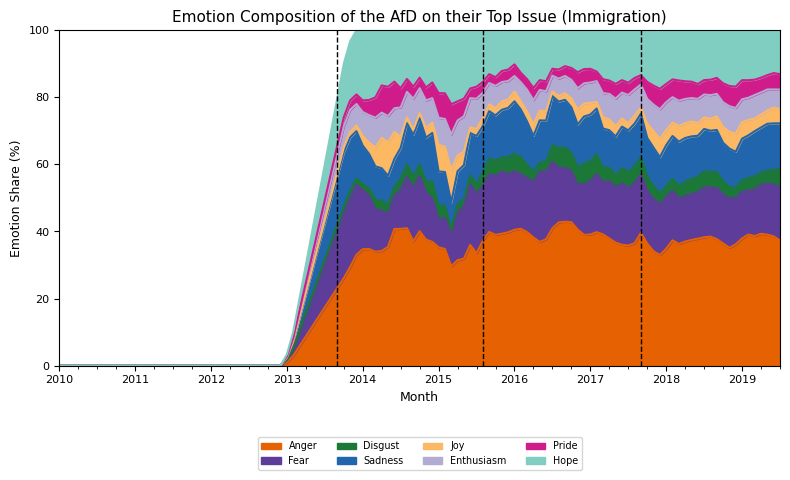

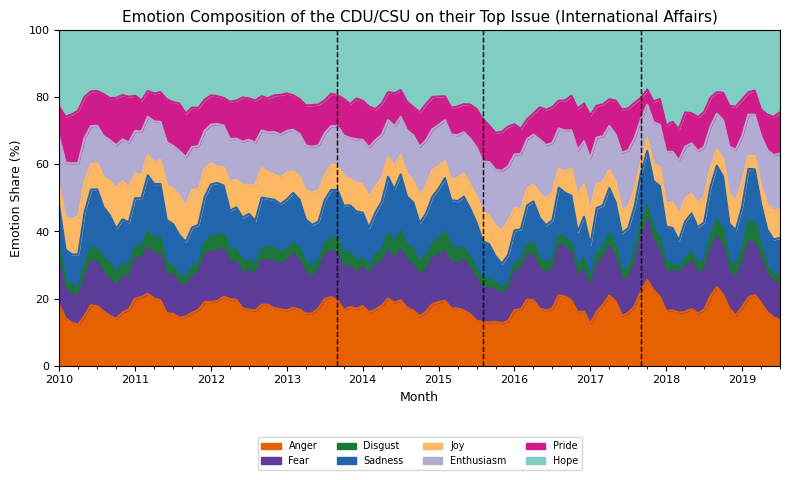

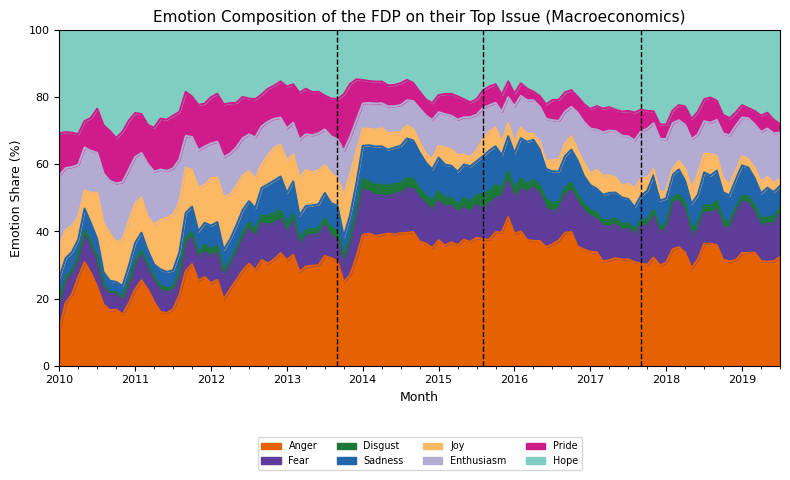

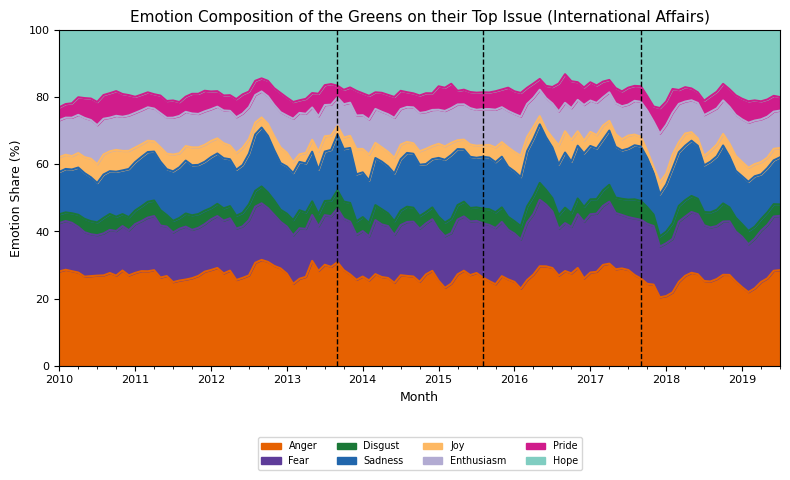

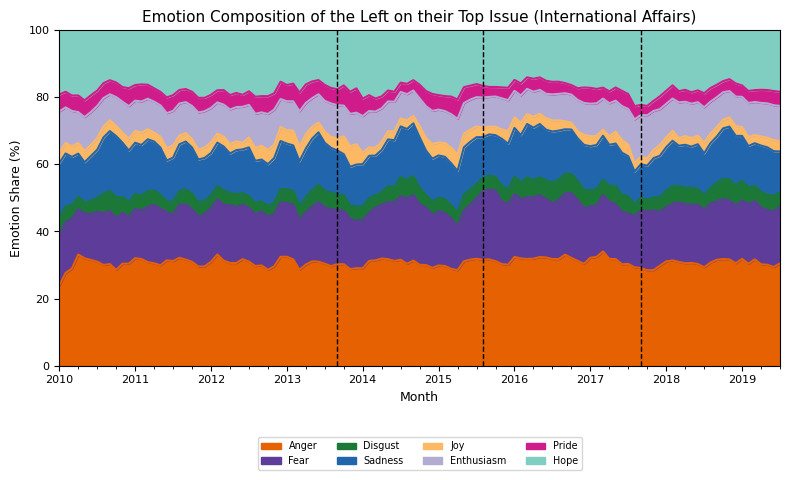

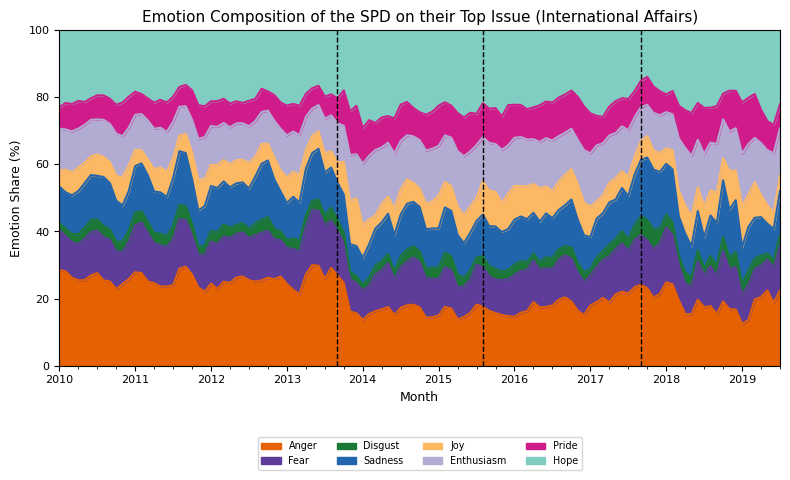

In [93]:
# identify top issue per party
top_issues_per_party = (
    df_gelectra.groupby(['party', 'issue_label'])
    .size()
    .reset_index(name='n_press_releases')
    .sort_values(['party', 'n_press_releases'], ascending=[True, False])
    .groupby('party')
    .first()
    .reset_index()
)

# filter `df_gelectra` for only each party's top issue
df_top_issues = pd.merge(df_gelectra, top_issues_per_party[['party', 'issue_label']], on=['party', 'issue_label'])

# prepare color and column info
emotion_order = list(emotion_colors.keys())
share_cols_ordered = [f"{emotion}_share" for emotion in emotion_order]

# ensure datetime format for month
df_top_issues['month'] = pd.to_datetime(df_top_issues['date']).dt.to_period('M').dt.to_timestamp()
full_month_index = pd.date_range(start='2010-01-01', end=df_top_issues['month'].max(), freq='MS')

# event dates
election_2013 = pd.to_datetime('2013-09-22')
election_2017 = pd.to_datetime('2017-09-24')
merkel_press_conf = pd.to_datetime('2015-08-31')
event_dates = [election_2013, merkel_press_conf, election_2017]

# plot for each party
for party in df_top_issues['party'].unique():
    df_party = df_top_issues[df_top_issues['party'] == party].copy()
    issue_label = df_party['issue_label'].iloc[0]

    df_grouped = df_party.groupby('month')[share_cols_ordered].mean()
    df_grouped = df_grouped.div(df_grouped.sum(axis=1), axis=0) * 100
    df_grouped = df_grouped.reindex(full_month_index)

    if party == "AfD":
        founding_date = pd.to_datetime("2013-01-01")
        df_grouped.loc[df_grouped.index < founding_date] = 0

    df_grouped = df_grouped.interpolate(method='linear', limit_direction='both')
    df_grouped = df_grouped.rolling(window=3, min_periods=1).mean()

    # plot
    plt.figure(figsize=(8, 5))
    df_grouped.plot(
        kind='area',
        stacked=True,
        ax=plt.gca(),
        color=[emotion_colors[e] for e in emotion_order]
    )

    for date in event_dates:
        plt.axvline(date, color='black', linestyle='--', linewidth=1)

    plt.title(f"Emotion Composition of the {party} on their Top Issue ({issue_label})", fontsize=11)
    plt.xlabel("Month", fontsize=9)
    plt.ylabel("Emotion Share (%)", fontsize=9)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.ylim(0, 100)

    handles, labels = plt.gca().get_legend_handles_labels()
    new_labels = [label.replace('_share', '').title() for label in labels]
    plt.legend(
        handles=handles,
        labels=new_labels,
        loc='upper center',
        bbox_to_anchor=(0.5, -0.2),
        ncol=4,
        fontsize='x-small'
    )

    plt.tight_layout()
    plt.show()

-- *Stacked area plot of emotion share by party over time for each party's OWNED issue*

In [94]:
# define each party's owed issue
owned_issues_by_party = {
    "Greens": [4, 7],         # Agriculture, Environment
    "SPD": [6, 15],           # Education, Domestic Commerce
    "CDU/CSU": [2, 15],       # Civil Rights, Domestic Commerce
    "FDP": [15, 1],           # Domestic Commerce, Macroeconomics
    "Left": [13, 5],          # Social Welfare, Labor
    "AfD": [9, 192]           # Immigration, European Integration
}

In [95]:
# prepare for plot

# prepare emotion share columns
emotion_order = list(emotion_colors.keys())
share_cols_ordered = [f"{emo}_share" for emo in emotion_order]

# ensure datetime format for monthly aggregation
df_gelectra['month'] = pd.to_datetime(df_gelectra['date']).dt.to_period('M').dt.to_timestamp()
full_month_index = pd.date_range(start='2010-01-01', end=df_gelectra['month'].max(), freq='MS')

# event markers
event_dates = [
    pd.to_datetime('2013-09-22'),
    pd.to_datetime('2015-08-31'),
    pd.to_datetime('2017-09-24')
]

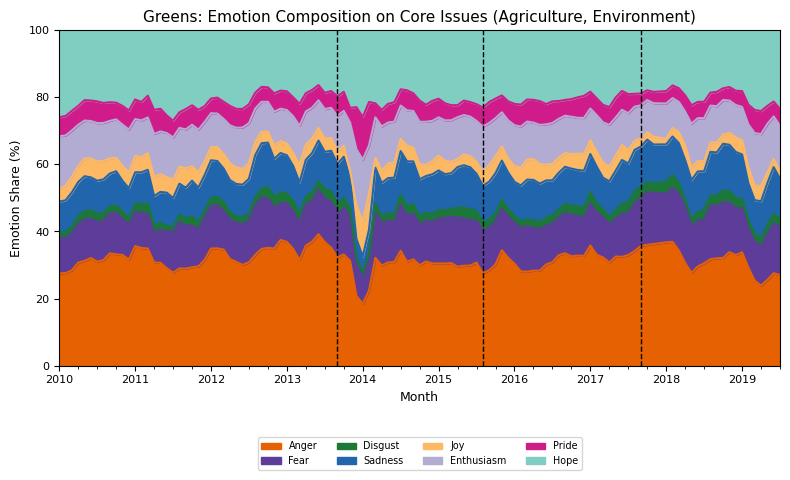

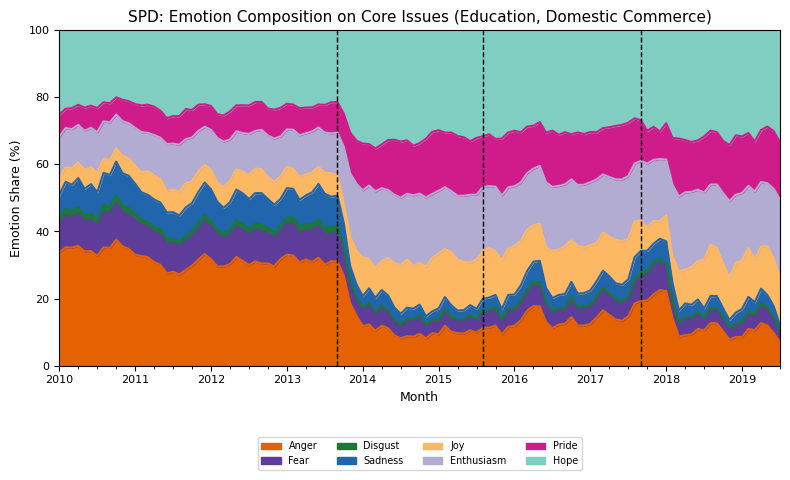

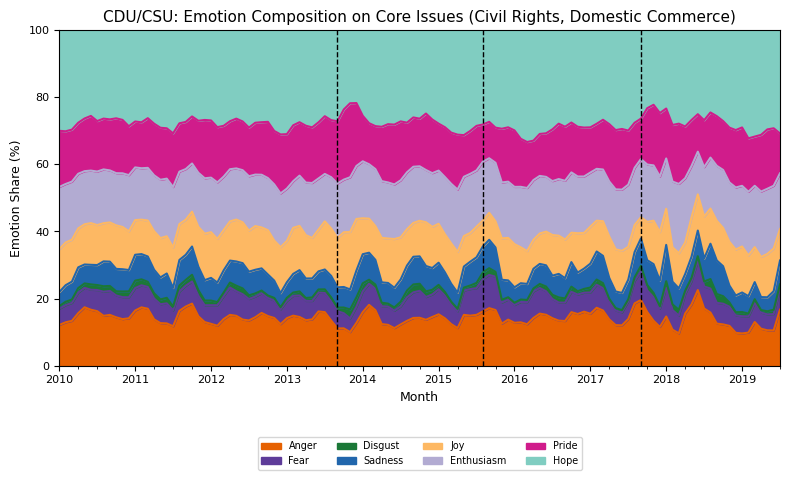

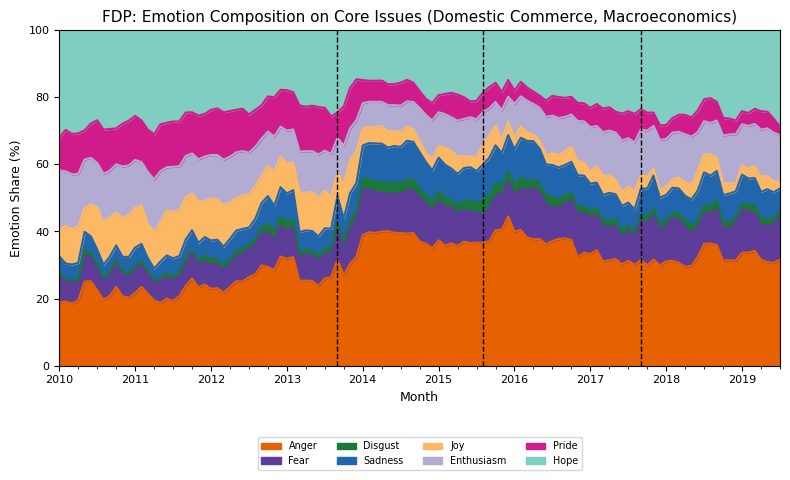

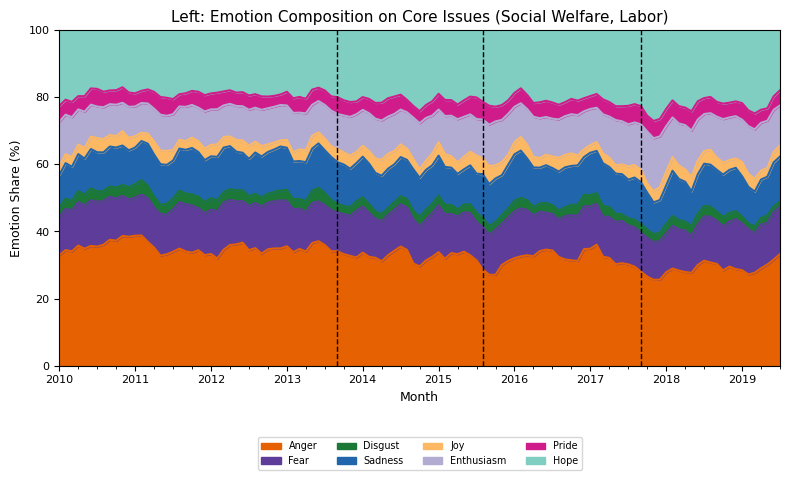

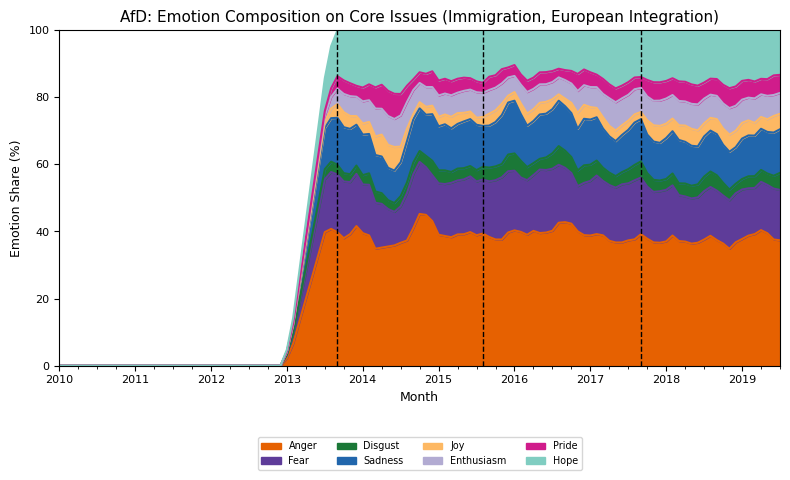

In [96]:
# plot for each party
for party, issue_codes in owned_issues_by_party.items():
    df_party_issue = df_gelectra[
        (df_gelectra['party'] == party) &
        (df_gelectra['issue_mono'].isin(np.atleast_1d(issue_codes)))
    ].copy()

    if df_party_issue.empty:
        print(f"Skipping {party} — no data for owned issues: {issue_codes}")
        continue
    
    # group by month and average
    df_grouped = df_party_issue.groupby('month')[share_cols_ordered].mean()
    df_grouped = df_grouped.div(df_grouped.sum(axis=1), axis=0) * 100
    df_grouped = df_grouped.reindex(full_month_index)

    if party == "AfD":
        founding_date = pd.to_datetime("2013-01-01")
        df_grouped.loc[df_grouped.index < founding_date] = 0

    df_grouped = df_grouped.interpolate(method='linear', limit_direction='both')
    df_grouped = df_grouped.rolling(window=3, min_periods=1).mean()

    # plot
    plt.figure(figsize=(8, 5))
    df_grouped.plot(
        kind='area',
        stacked=True,
        ax=plt.gca(),
        color=[emotion_colors[e] for e in emotion_order]
    )

    for date in event_dates:
        plt.axvline(date, color='black', linestyle='--', linewidth=1)

    issue_labels = [issue_map.get(code, f"Issue {code}") for code in np.atleast_1d(issue_codes)]
    issue_label_str = ", ".join(issue_labels)
    plt.title(f"{party}: Emotion Composition on Core Issues ({issue_label_str})", fontsize=11)
    plt.xlabel("Month", fontsize=9)
    plt.ylabel("Emotion Share (%)", fontsize=9)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.ylim(0, 100)

    # clean legend
    handles, labels = plt.gca().get_legend_handles_labels()
    new_labels = [label.replace('_share', '').title() for label in labels]
    plt.legend(
        handles=handles,
        labels=new_labels,
        loc='upper center',
        bbox_to_anchor=(0.5, -0.2),
        ncol=4,
        fontsize='x-small'
    )

    plt.tight_layout()
    plt.show()

-- *Look at most frequently discussed issues*

In [97]:
# count how many press releases cover each issue
issue_counts = df_gelectra['issue_label'].value_counts().reset_index()
issue_counts.columns = ['issue_label', 'n_press_releases']

# preview the top issues
print(issue_counts.head(10))

             issue_label  n_press_releases
0  International Affairs              5629
1           Civil Rights              3161
2          Law and Crime              2800
3                  Labor              2786
4      Domestic Commerce              2662
5   European Integration              2444
6              Education              2294
7         Macroeconomics              2273
8            Immigration              2221
9                 Energy              2071


In [98]:
# count number of press releases per party per issue
issue_party_counts = df_gelectra.groupby(['party', 'issue_label']).size().reset_index(name='n_press_releases')

# get top N
top_issues_per_party = (
    issue_party_counts
    .sort_values(['party', 'n_press_releases'], ascending=[True, False])
    .groupby('party')
    .head(3)
    .reset_index(drop=True)
)

# show top issues by party
print(top_issues_per_party)

      party            issue_label  n_press_releases
0       AfD            Immigration               559
1       AfD   European Integration               415
2       AfD           Civil Rights               358
3   CDU/CSU  International Affairs               991
4   CDU/CSU           Civil Rights               597
5   CDU/CSU      Domestic Commerce               577
6       FDP         Macroeconomics               713
7       FDP  International Affairs               658
8       FDP          Law and Crime               445
9    Greens  International Affairs              1251
10   Greens            Agriculture               619
11   Greens                  Labor               543
12     Left  International Affairs              1471
13     Left                  Labor              1111
14     Left                Defense               847
15      SPD  International Affairs               980
16      SPD              Education               869
17      SPD      Domestic Commerce            

In [99]:
# filter to top N issues
top_issues = issue_counts['issue_label'].head(7).tolist()

# filter the dataset
df_top_issues = df_gelectra[df_gelectra['issue_label'].isin(top_issues)].copy()

In [100]:
# melt and prepare data for plotting

# melt emotion columns
df_melted_issues = df_top_issues.melt(
    id_vars=['month', 'party', 'issue_label'],
    value_vars=emotion_cols,
    var_name='emotion',
    value_name='value'
)
df_melted_issues['emotion'] = df_melted_issues['emotion'].str.title()

-- *Group-level emotion distributions by issue*

In [101]:
# table average emotion share per issue
df_emotion_share = df_gelectra.melt(
    id_vars=['issue_label'],
    value_vars=[f"{e}_share" for e in emotion_colors.keys()],
    var_name='emotion',
    value_name='share'
)

df_emotion_share['emotion'] = df_emotion_share['emotion'].str.replace('_share', '').str.title()

avg_share_by_issue = (
    df_emotion_share
    .groupby(['issue_label', 'emotion'])['share']
    .mean()
    .reset_index()
)

In [102]:
# ensure lowercase emotion labels to match emotion_colors
avg_share_by_issue['emotion'] = avg_share_by_issue['emotion'].str.lower()

-- *Plot top 7 most discussed issues*

In [103]:
# get top 7 most discussed issues
top_issues = (
    df_gelectra['issue_mono'].value_counts()
    .head(7)
    .index.tolist()
)

# filter data to only those issues
df_top_issues = df_gelectra[df_gelectra['issue_mono'].isin(top_issues)].copy()

In [104]:
# list of emotion share columns
emotion_share_cols = [col for col in df_gelectra.columns if col.endswith('_share')]

# melt emotion columns
df_melted_intensity = df_top_issues.melt(
    id_vars=['issue_label'],
    value_vars=emotion_cols,
    var_name='emotion',
    value_name='intensity'
)

# melt share columns
df_melted_share = df_top_issues.melt(
    id_vars=['issue_label'],
    value_vars=emotion_share_cols,
    var_name='emotion',
    value_name='share'
)
df_melted_share['emotion'] = df_melted_share['emotion'].str.replace('_share', '').str.lower()

# group by issue and emotion
avg_intensity_by_issue = df_melted_intensity.groupby(['issue_label', 'emotion'])['intensity'].mean().reset_index()
avg_share_by_issue = df_melted_share.groupby(['issue_label', 'emotion'])['share'].mean().reset_index()

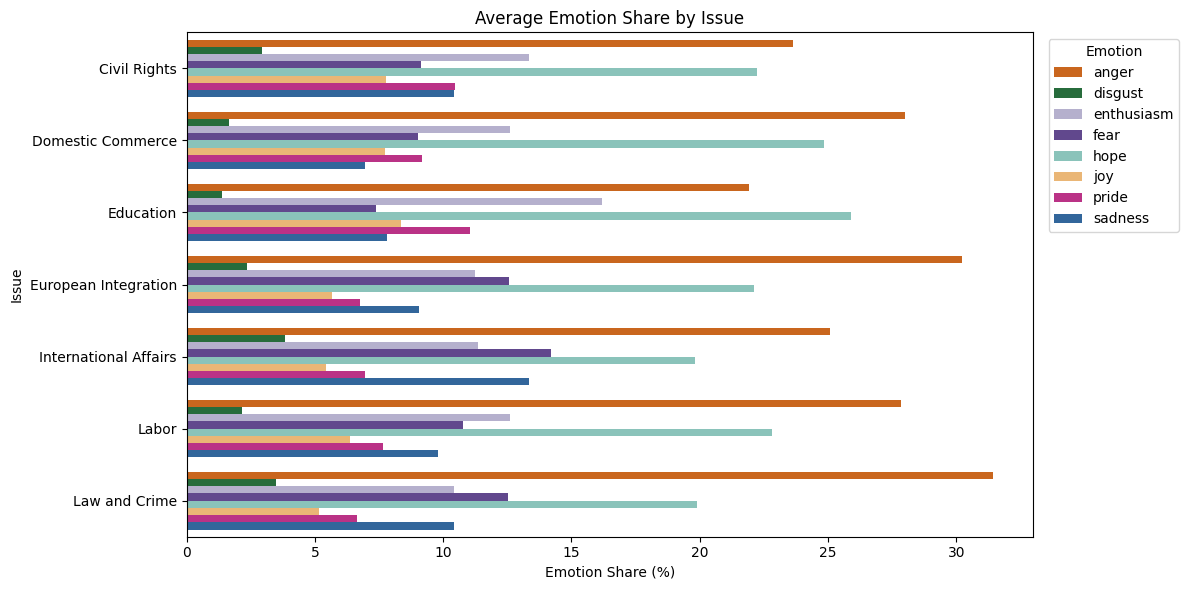

In [105]:
# plot average emotion share by issue
plt.figure(figsize=(12, 6))
sns.barplot(
    data=avg_share_by_issue,
    x='share',
    y='issue_label',
    hue='emotion',
    palette=emotion_colors
)
plt.title("Average Emotion Share by Issue")
plt.xlabel("Emotion Share (%)")
plt.ylabel("Issue")
plt.legend(title='Emotion', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()